# 1. First version: 첫 머신러닝 시도
- 범주형 데이터(장르, 제작국가) encoding
- raw데이터로 첫 시도한 머신러닝

## 01. import, encoding, 분포도
- 장르:  여러 개의 장르가 있는 복수의 장르가 있기에 Multi-Hot Encoding (다중 원핫 인코딩) 시도
- 제작 국가: Label Encoding(레이블 인코딩)

In [29]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings(action='ignore')
from IPython.display import Image

In [30]:
# 데이터 불러오기
df = pd.read_excel('../data/file/ml_all.xlsx', index_col=0)

In [31]:
# 제작국가 인코딩한 컬럼으로 대체
df['production_country'] = df['production_country_code']

In [32]:
# 장르 문자열을 분리하여 개별 항목으로 변환
df['genre'] = df['genre'].str.split(', ')

# 각 영화에 대한 모든 고유한 장르를 수집
all_genres = set(genre for sublist in df['genre'] for genre in sublist)

# Multi-Hot Encoding을 수행할 데이터프레임 초기화
for genre in all_genres:
    df[genre] = 0

# 각 영화에 대해 해당하는 장르에 1 할당
for index, row in df.iterrows():
    for genre in row['genre']:
        df.at[index, genre] = 1

# 장르 열을 삭제
df = df.drop(columns=['genre'])

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 601 entries, 0 to 600
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   korean_title                  601 non-null    object 
 1   english_title                 601 non-null    object 
 2   year                          601 non-null    int64  
 3   total_season_num              601 non-null    int64  
 4   runtime                       601 non-null    int64  
 5   age_rating                    601 non-null    int64  
 6   production_country            601 non-null    int64  
 7   PCA                           601 non-null    float64
 8   genre_len                     601 non-null    int64  
 9   production_country_freq_code  601 non-null    int64  
 10  production_country_code       601 non-null    int64  
 11  seson_n                       601 non-null    int64  
 12  i_s1_rate                     601 non-null    float64
 13  i_s1_rate_

In [33]:
# 분포도

# 첫 번째 그래프: 6개의 속성 히스토그램
fig1 = make_subplots(rows=2, cols=3, subplot_titles=['imdb_s2 평점', 'imdb_s2 평점 참여 수', 'watcha_s2 평점', 'watcha_s2 평점 참여 수', 's2 평점 유지도', 's2 평점 참여 수 유지도'])
columns1 = ['i_s2_rate', 'i_s2_rate_cnt', 'w_s2_rate', 'w_s2_rate_cnt', 's2_rate_retention', 's2_rate_cnt_retention']

for i, col in enumerate(columns1):
    fig1.add_trace(go.Histogram(x=df[col], name=col), row=(i // 3) + 1, col=(i % 3) + 1)

fig1.update_layout(title_text='y값(다음 시즌의 흥행도를 나타내는 컬럼)', showlegend=False)

# 두 번째 그래프: 8개의 속성 히스토그램
fig2 = make_subplots(rows=2, cols=4, subplot_titles=['런타임', '연령 제한', '제작국가', '시즌 번호', '전반적인 흥행(PCA)', '장르 다양성', '시즌1의 gaps_days', '시즌 간의gaps_days'])
columns2 = ['runtime', 'age_rating', 'production_country', 'seson_n', 'PCA', 'genre_len', 's1_gap_days', 'season_gaps_days']

for i, col in enumerate(columns2):
    fig2.add_trace(go.Histogram(x=df[col], name=col), row=(i // 4) + 1, col=(i % 4) + 1)

fig2.update_layout(title_text='x값_1(드라마의 특징)', showlegend=False)

# 세 번째 그래프: 6개의 속성 히스토그램
fig3 = make_subplots(rows=2, cols=3, subplot_titles=['imdb_s1 평점', 'imdb_s1 평점 참여 수', 'watcha_s1 평점', 'watcha_s1 평점 참여 수', 's1 평점 유지도', 's1 평점 참여 수 유지도'])
columns3 = ['i_s1_rate', 'i_s1_rate_cnt', 'w_s1_rate', 'w_s1_rate_cnt', 's1_rate_retention', 's1_rate_cnt_retention']

for i, col in enumerate(columns3):
    fig3.add_trace(go.Histogram(x=df[col], name=col), row=(i // 3) + 1, col=(i % 3) + 1)

fig3.update_layout(title_text='x값_2(이전 시즌의 흥행도를 나타내는 컬럼)', showlegend=False)

# 그래프 출력
fig1.show()
fig2.show()
fig3.show()

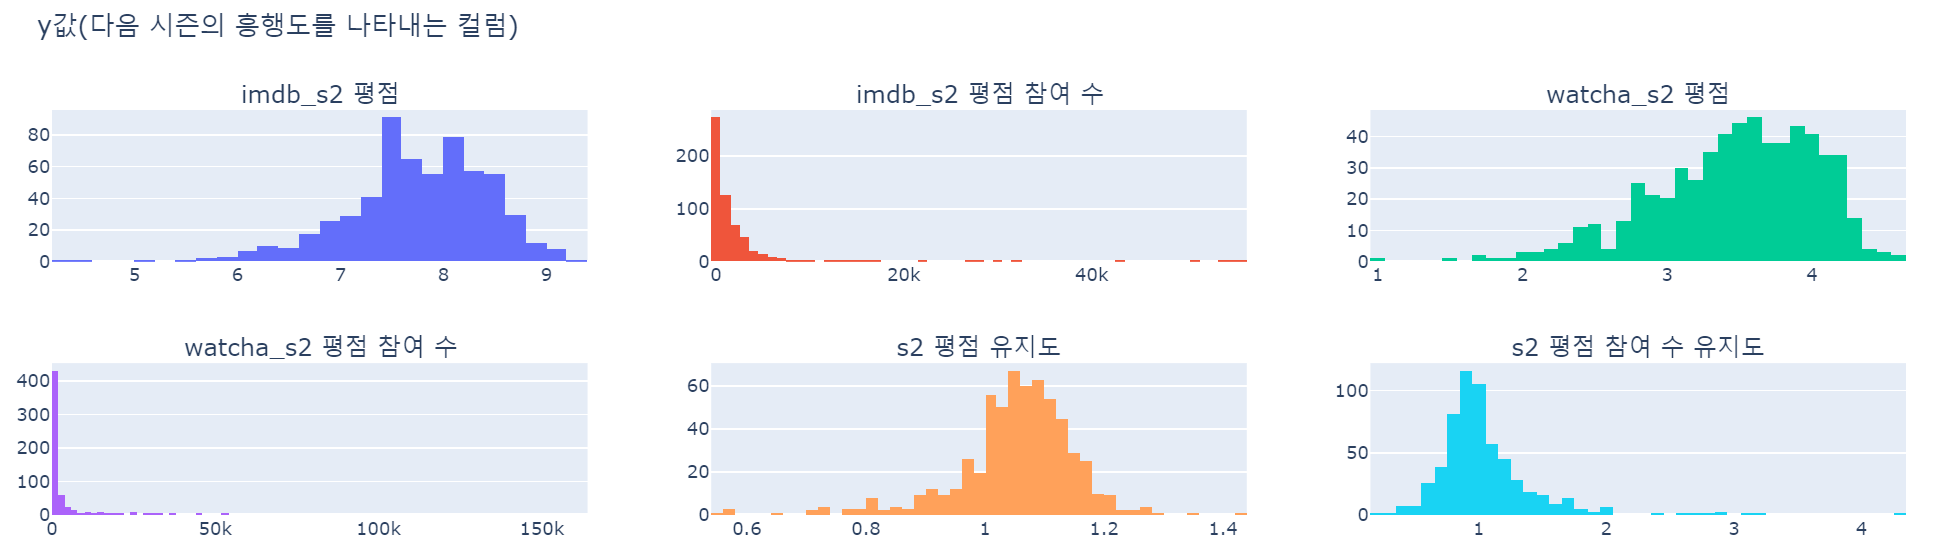

In [34]:
Image(filename='../data/image/v1_1.png') 

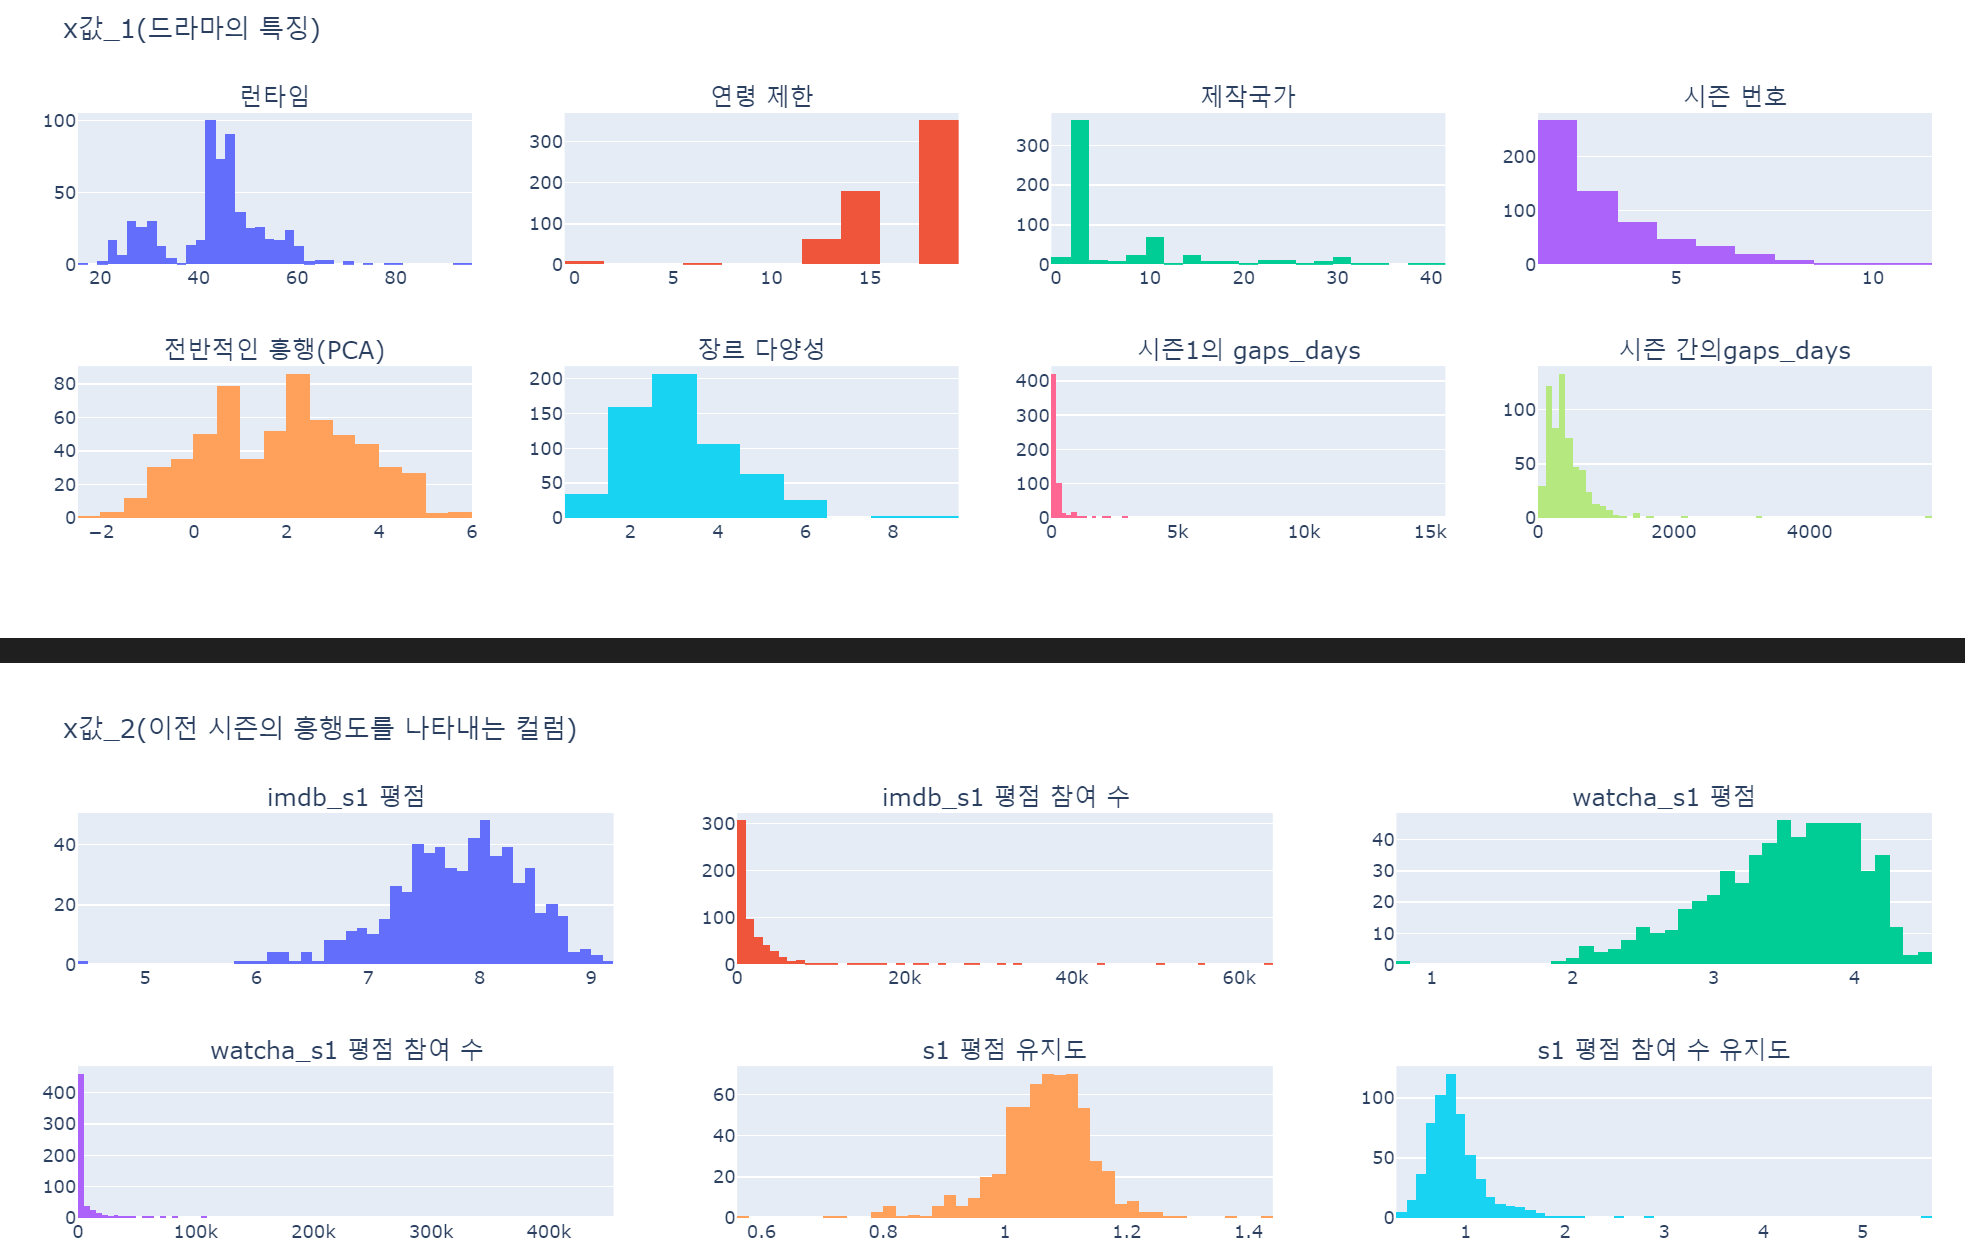

In [35]:
Image(filename='../data/image/v1_2.png')

## 02-1. y값(다음 시즌 흥행도) 설정과 y값의 그래프

In [36]:
# 각 요소 계산
rate = (0.8 * df['i_s2_rate']) + (0.2 * df['w_s2_rate'])
cnt = (0.8 * df['i_s2_rate_cnt']) + (0.2 * df['w_s2_rate_cnt'])
ret = (0.4 * df['s2_rate_retention']) + (0.6 * df['s2_rate_cnt_retention']) *10

# 총 점수 계산
total = (0.3 * rate + 0.5 * cnt + 0.2 * ret) *10

# 점수를 데이터프레임에 추가
df['score'] = total

In [37]:
df = df[['runtime','age_rating','production_country','PCA','genre_len','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_retention','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days','score',
         'Made in Europe', 'SF', '가족', '공포', '드라마', '로맨스', '범죄', '서부', '스릴러', '스포츠', '액션', '역사', '음악', '전쟁', '코미디' ,'판타지']]

### Score(y값) 그래프

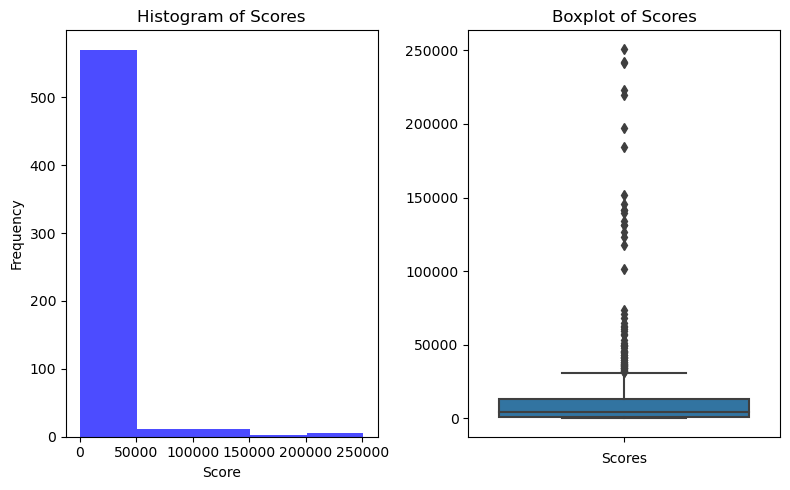

In [38]:
# 서브플롯 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# 첫 번째 서브플롯에 히스토그램
axes[0].hist(df['score'], bins=5, color='blue', alpha=0.7)
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Scores')

# 두 번째 서브플롯에 박스플롯
sns.boxplot(data=df, y="score", ax=axes[1])
axes[1].set_title('Boxplot of Scores')
axes[1].set_xlabel('Scores')
axes[1].set_ylabel('')

# 플롯 보여주기
plt.tight_layout()
plt.show()

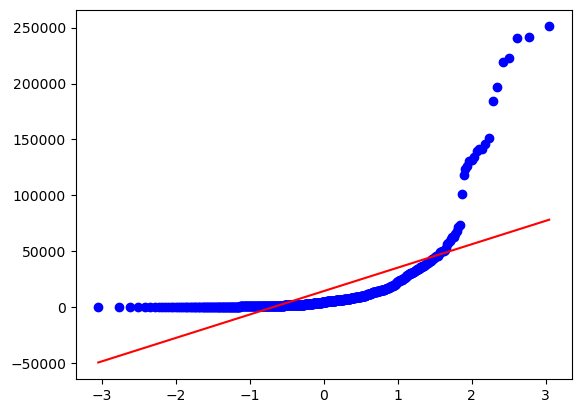

In [39]:
# QQ plot 그리기
stats.probplot(df['score'], dist="norm", plot=plt)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.show()

## 02-2. Modeling
- DecisionTreeRegressor
- RandomForestRegressor
- KNeighborsRegressor
- XGBRegressor
- AdaBoostRegressor
- LGBMRegressor
- GradientBoostingRegressor
- LinearRegression

In [40]:
X = df.drop(['score'], axis=1)  # 'score' 열을 제외한 모든 열 선택
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [41]:
# DecisionTreeRegressor 모델 초기화
dt_model = DecisionTreeRegressor(random_state=13)
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)

# 회귀 모델의 성능 평가
dt_mse = mean_squared_error(y_test, predictions)
dt_mae = mean_absolute_error(y_test, predictions)
dt_r2 = r2_score(y_test, predictions)

In [42]:
# RandomForestRegressor 모델 초기화
rf_model = RandomForestRegressor(random_state=13)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

# 회귀 모델의 성능 평가
rf_mse = mean_squared_error(y_test, predictions)
rf_mae = mean_absolute_error(y_test, predictions)
rf_r2 = r2_score(y_test, predictions)

In [43]:
# KNeighborsRegressor 모델 초기화
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# 회귀 모델의 성능 평가
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

In [44]:
# XGBRegressor 모델 초기화
xgb_model = XGBRegressor(random_state=13)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# 회귀 모델의 성능 평가
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

In [45]:
# AdaBoostRegressor 모델 초기화
ada_model = AdaBoostRegressor(random_state=13)
ada_model.fit(X_train, y_train)
ada_predictions = ada_model.predict(X_test)

# 회귀 모델의 성능 평가
ada_mse = mean_squared_error(y_test, ada_predictions)
ada_mae = mean_absolute_error(y_test, ada_predictions)
ada_r2 = r2_score(y_test, ada_predictions)

In [ ]:
# LGBMRegressor 모델 초기화
lgb_model = LGBMRegressor(random_state=13)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)

# 회귀 모델의 성능 평가
lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_r2 = r2_score(y_test, lgb_predictions)

In [47]:
# GradientBoostingRegressor 모델 초기화
gbr_model = GradientBoostingRegressor(random_state=13)
gbr_model.fit(X_train, y_train)
gbr_predictions = gbr_model.predict(X_test)

# 회귀 모델의 성능 평가
gbr_mse = mean_squared_error(y_test, gbr_predictions)
gbr_mae = mean_absolute_error(y_test, gbr_predictions)
gbr_r2 = r2_score(y_test, gbr_predictions)

In [48]:
# LinearRegression 모델 초기화
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# LinearRegression 모델의 성능 평가
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

---

## 02-3. 결과

In [49]:
# 결과를 데이터프레임으로 만듭니다.
model_result = pd.DataFrame({
    'MSE': [dt_mse, rf_mse, knn_mse, xgb_mse, ada_mse, lgb_mse, gbr_mse, lr_mse],
    'MAE': [dt_mae, rf_mae, knn_mae, xgb_mae, ada_mae, lgb_mae, gbr_mae, lr_mae],
    'R2': [dt_r2, rf_r2, knn_r2, xgb_r2, ada_r2, lgb_r2, gbr_r2, lr_r2]
}, index=['DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'XGBoostRegressor', 'AdaBoostRegressor', 'LightGBMRegressor', 'GradientBoostingRegressor', 'LinearRegression'])

# 소수점 3자리까지 반올림합니다.
model_result = model_result.round(3)

# 결과 출력
print(model_result)

                                    MSE       MAE     R2
DecisionTreeRegressor      1.092826e+08  3231.884  0.902
RandomForestRegressor      8.967085e+07  2684.364  0.919
KNeighborsRegressor        1.860937e+08  3559.189  0.833
XGBoostRegressor           1.597248e+08  3318.091  0.856
AdaBoostRegressor          1.521658e+08  9387.700  0.863
LightGBMRegressor          1.378293e+08  3401.291  0.876
GradientBoostingRegressor  4.977859e+07  2347.169  0.955
LinearRegression           4.935418e+07  4061.095  0.956


In [50]:
# prompt: 제일 좋은 성능 두가지
print("MSE 기준")
print(model_result.sort_values(by=['MSE'], ascending=True).head(3))
print(" ")

print("MAE 기준")
print(model_result.sort_values(by=['MAE'], ascending=True).head(3))
print(" ")

print("R2 기준")
print(model_result.sort_values(by=['R2'], ascending=True).head(3))

MSE 기준
                                    MSE       MAE     R2
LinearRegression           4.935418e+07  4061.095  0.956
GradientBoostingRegressor  4.977859e+07  2347.169  0.955
RandomForestRegressor      8.967085e+07  2684.364  0.919
 
MAE 기준
                                    MSE       MAE     R2
GradientBoostingRegressor  4.977859e+07  2347.169  0.955
RandomForestRegressor      8.967085e+07  2684.364  0.919
DecisionTreeRegressor      1.092826e+08  3231.884  0.902
 
R2 기준
                              MSE       MAE     R2
KNeighborsRegressor  1.860937e+08  3559.189  0.833
XGBoostRegressor     1.597248e+08  3318.091  0.856
AdaBoostRegressor    1.521658e+08  9387.700  0.863


### LinearRegression 기준으로 learning_curve, 산점도

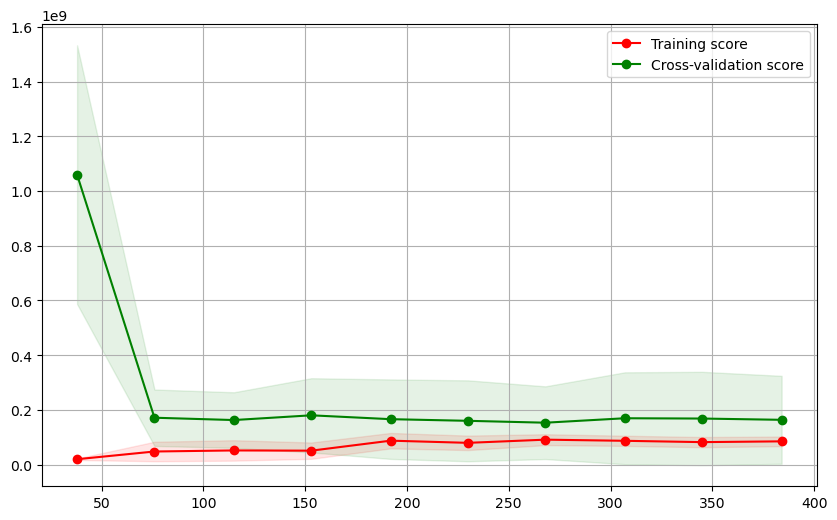

In [51]:
# learning curve 계산
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), return_times=True
)

# 성능 지표 계산
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("")
plt.ylabel("")
plt.title("")
plt.legend(loc="best")
plt.grid()
plt.show()

- 현재 모델 학습이 과적합된 것을 확인함(숫자 단위 주의)

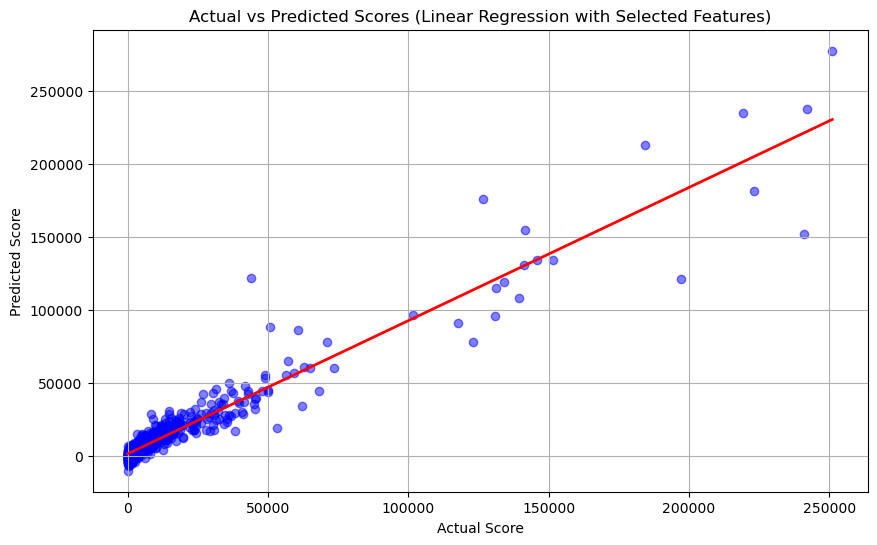

In [52]:
# 예측값 계산
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# 훈련 데이터와 테스트 데이터를 합친 전체 데이터셋
X_combined = np.vstack((X_train, X_test))
y_combined = np.concatenate((y_train, y_test))
y_combined_pred = np.concatenate((y_train_pred, y_test_pred))

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_combined, y_combined_pred, color='blue', alpha=0.5)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Actual vs Predicted Scores (Linear Regression with Selected Features)')
plt.grid(True)

# 회귀선 그리기
# y = mx + c 형태의 직선의 기울기(m)와 절편(c)을 계산합니다.
m, c = np.polyfit(y_combined, y_combined_pred, 1)
x_range = np.linspace(min(y_combined), max(y_combined), 100)
y_range_pred = m * x_range + c
plt.plot(x_range, y_range_pred, color='red', linewidth=2)

plt.show()

---